In [1]:
import os
import scvi
import scgen
import rpy2
import scib
import json
import torch
import anndata
import logging
import warnings
import scanorama
import anndata2ri
import matplotlib
import liana as li
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import cell2cell as c2c
import plotnine as p9
import scrublet as scr
import doubletdetection
import decoupler as dc
from rpy2.robjects import r
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from liana.method import cellphonedb
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be r

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})


UsageError: Cell magic `%%R` not found.


In [4]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.


-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                                     22.0.0
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
adjustText                                  NA
anndata2ri                                  1.1
annoy                                       NA
appnope                                     0.1.2
asttokens                                   NA
astunparse                                  1.6.3
attr                                        21.4.0
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
boto3                                       1.26.32
botocore                                    1.29.32
bottleneck                                  1.3.5
brotli                                      NA
cell2cell                                   0.6.6
certifi               

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Cell-Cell Communication</a>

# 1. Reading in the data

### [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
adata_annot = sc.read_h5ad('../data/processed/adata_annotated.h5ad')
adata_annot = adata_annot[~adata_annot.obs.cell_type.isin(['Endothelial'])]

In [6]:
#adata_annot = adata_annot[:, adata_annot.var.highly_variable=="True"]
adata_annot

View of AnnData object with n_obs × n_vars = 65297 × 16590
    obs: 'projid', 'fastq', 'Subject', 'sample', 'libraryid', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic diagnosis of AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'sampleid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Subject_colors', 'amyloid.group_colors', 'braaksc_colors', 'dendrogram_louvain_0.5', 'hvg', 'log1p', 'louvain', 'louvain_0.5_colors', 'louvain_1.0_colors', 'msex_x_colors'

# 2 **Cell-Cell Communication**

## `Predicting inter-cellular crosstalk between pair of clusters, one cluster being the source and the other the target of a CCC event.`


**Summary**:

- In general, single cells are clustered by their gene expression profile and cell type identities are assigned to the clusters based on known gene markers. Then, CCC tools can predict intercellular crosstalk between any pair of clusters, one cluster being the source and the other the target of a CCC event. 

- CCC events are thus typically represented as a one-to-one interaction between a transmitter and receiver protein, accordingly expressed by the source and target cell clusters. 

- The information about which transmitter binds to which receiver is extracted from diverse sources of prior knowledge. Roughly, CCC tools then estimate the likelihood of crosstalk based on the expression level of the transmitter and the receiver in the source and target clusters, respectively. 

- Every tool has two major components: a resource of prior knowledge on CCC (interactions), and a method to estimate CCC from the known interactions and the dataset at hand. Most tools have been published as the combination of one resource and one method, but in principle any resource could be combined with any method.

## 2.1 **Background**

Cell communication is a process by which cells react to stimuli from their environment and also from themselves. In multicellular organisms, the dynamic coordination of cells, also called cell-cell communication (CCC), is involved in many biological processes, such as apoptosis and cell migration, and is consequently essential in homeostasis and disease.

CCC commonly focuses on protein-mediated interactions, most typically perceived as a secreted ligand binding to its corresponding plasma membrane receptor. `However, this picture can be broadened to include secreted enzymes, extra-cellular matrix proteins, transporters, and interactions that require the physical contact between cells, such as cell-cell adhesion proteins and gap junctions `

Cell communication is therefore not independent of other processes, but the contrary, as external stimuli commonly elicit a downstream response. In the case of CCC, this is typically perceived as the induction of canonical pathways and downstream transcription factors in the cells receiving the signal, or receiver cells.

Ultimately these external stimuli alter the function of receiver cells, and this alteration is further propagated via the subsequent interaction of these cells with their microenvironment. 

Traditionally, the study of CCC required specialized in-situ biochemical assays, such proximity labelling proteomics, co-immunoprecipitation, and yeast two-hybrid screening [**Armingol et al., 2021**](http://www.nature.com/articles/s41576-020-00292-x). Yet, the rapid developments and dropping costs of transcriptomics data generation has enabled a paradigm shift away from focusing on which types of cells are present, but rather on the relationships between them [**Almet et al., 2021**](https://linkinghub.elsevier.com/retrieve/pii/S2452310021000081 ). 

`As a consequence, CCC inference from single-cell data is now becoming a routine approach, capable of providing a system-level hypotheses of intercellular crosstalk in vivo.`

## 2.2 **Motivation**

From the differential pathway analysis, we observe that certain pathways that are specific to some cell-types are instead differentially perturbed in other cell-types. This could be arise from cell autonomous processes or from more complex mechanisms involving paracrine signalling from other cell types. To accurately delineate this, we perform cell-cell communication analysis in this study using the procedures described in [**Single-cell Best Practices**](https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html)

## 2.3. **Methods**

There exists a number of tools for CCC inference from single-cell transcriptomics. `These tools are classified into two broad groups`:

- `Methods that predict CCC interactions alone, commonly referred to as ligand-receptor inference methods` (e.g. [**Efremova et al., 2020**](http://www.nature.com/articles/s41596-020-0292-x), [**Hou et al., 2020**](https://www.nature.com/articles/s41467-020-18873-z), [**Jin et al., 2021**](http://dx.doi.org/10.1038/s41467-021-21246-9), [**Raredon et al., 2022**](http://dx.doi.org/10.1038/s41598-022-07959-x))

- `Methods that additionally estimate intracellular activities induced by CCC` (e.g. [**Browaeys et al., 2020**](http://www.nature.com/articles/s41592-019-0667-5), [**Hu et al., 2021**](https://advances.sciencemag.org/lookup/doi/10.1126/sciadv.abf1356), [**Wang et al., 2019**](https://academic.oup.com/nar/article/47/11/e66/5421812)). 

Both categories of tools use gene expression information as a proxy of protein abundance, and typically require the clustering of cells into biologically-meaningful groups such as cell types. `These CCC tools infer intercellular crosstalk between pairs of cell groups, one group being the source and the other the receiver of a CCC event.` CCC events are thus commonly represented as interactions between proteins, expressed by the source and receiver cell clusters.

`The information about the interacting proteins is commonly extracted from prior knowledge resources`.

#### **Ligand - Receptor Inference Methods**

- In the case of ligand-receptor methods, the interactions can also be represented by heteromeric protein complexes, as different subunit combinations can induce distinct responses and the inclusion of protein complex information has been shown to reduce false positive rates [**Efremova et al., 2020**](http://www.nature.com/articles/s41596-020-0292-x), [**Jin et al., 2021**](http://dx.doi.org/10.1038/s41467-021-21246-9), [**Liu et al., 2022**](http://dx.doi.org/10.1186/s13059-022-02783-y).

#### **Intercellular Signalling Methods**

- On the other hand, the approaches that model intracellular signalling also leverage the functional information in receiver cell types, and thus require additional information such as intracellular protein-protein interaction network and/or gene regulatory interactions.


Recent work has highlighted that the choice of method and/or resource can lead to limited consensus in inferred predictions when using different tools [**Dimitrov et al., 2022**](https://www.nature.com/articles/s41467-022-30755-0), [**Liu et al., 2022**](http://dx.doi.org/10.1186/s13059-022-02783-y) [**Wang et al., 2022**](http://dx.doi.org/10.1093/bfgp/elac019), thus prompting caution when interpreting their output. Nevertheless, independent evaluations have shown that CCC methods are fairly robust to the introduction of noise [**Dimitrov et al., 2022**](https://www.nature.com/articles/s41467-022-30755-0), [**Liu et al., 2022**](http://dx.doi.org/10.1186/s13059-022-02783-y),[**Wang et al., 2022**](http://dx.doi.org/10.1093/bfgp/elac019), and are largely concordant with alternative data modalities such as intracellular signalling and spatial information [**Dimitrov et al., 2022**](https://www.nature.com/articles/s41467-022-30755-0), [**Liu et al., 2022**](http://dx.doi.org/10.1186/s13059-022-02783-y) [**Wang et al., 2022**](http://dx.doi.org/10.1093/bfgp/elac019).


## 2.4 **Approach**

Here, we implement the most common and simplest CCC approaches, i.e. ligand-receptor inference with `CellPhoneDB` [**Efremova et al., 2020**](http://www.nature.com/articles/s41596-020-0292-x) and `LIANA` [**Dimitrov et al., 2022**](https://www.nature.com/articles/s41467-022-30755-0). 


Then we apply `NicheNet` a CCC inference method with a focus on intracellular activities downstream of CCC events [**Browaeys et al., 2020**](http://www.nature.com/articles/s41592-019-0667-5) to model differential intercellular signalling.

### 2.4.1 **Ligand-receptor inference with `CellPhoneDB` [**Efremova et al., 2020**](http://www.nature.com/articles/s41596-020-0292-x)**

`CellPhoneDB` is one of the most commonly-used CCC tools, it represents `intercellular communication events as the average gene expression of the proteins involved in the interaction`. The proteins involved can also be can also take the form of heteromeric complexes, and in that case the minimum gene expression of the subunits is considered. In addition to the expression average, interaction significance is determined against a null distribution, generated by shuffling the cell group labels.

We will run CellPhoneDB on the data including pathological groups alone, as this method is designed for the inference of CCC events in “steady-state” data, or in other words, they are not meant to be used not across samples or conditions, but rather on a single condition or sample at a time. 

In a subsequent section, we employ other methods that apply ligand-receptor methods across conditions.

In addition to subseting the normal and diseased samples, we then group each condition by cell type, such that the CCC statistics that we get will reflect the cell types that were previously pre-defined.

In [7]:
adata_cond = {}
adata_cond['stim'] = adata_annot[adata_annot.obs["pathology.group"].isin(['early-pathology', 'late-pathology'])].copy()
adata_cond['ctrl'] = adata_annot[adata_annot.obs["pathology.group"].isin(['no-pathology'])].copy()

del adata_annot

# for cond in adata_cond.keys():
    
#     adata_cond[cond].X = adata_cond[cond].layers['counts']   
#     sc.pp.normalize_total(adata_cond[cond], layer='counts')
#     sc.pp.log1p(adata_cond[cond], layer='counts')

In [8]:
# import cellphonedb method via liana

for cond in adata_cond.keys():
    print(f'Estimating LR-scores for {cond}...')
    cellphonedb(adata_cond[cond], groupby="cell_type", use_raw=False, return_all_lrs=True, verbose=True, n_perms=200)

Estimating LR-scores for stim...
Using `.X`!
Converting mat to CSR format
0.09 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 31221 samples and 16590 features


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/_pipe_utils/_get_mean_perms.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


Estimating LR-scores for ctrl...
Using `.X`!
Converting mat to CSR format
0.09 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 34076 samples and 16590 features


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/_pipe_utils/_get_mean_perms.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Let’s examine the output from the CellPhoneDB method

In [9]:
adata_cond['stim'].uns["liana_res"].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
0,LGALS9,LGALS9,-0.054027,1.0,PTPRC,PTPRC,-0.135015,1.0,Astrocyte,Astrocyte,True,-0.094521,1.000
1,CD22,CD22,-0.351892,1.0,PTPRC,PTPRC,-0.135015,1.0,Astrocyte,Astrocyte,True,-0.243454,1.000
2,MRC1,MRC1,-0.068164,1.0,PTPRC,PTPRC,-0.135015,1.0,Astrocyte,Astrocyte,True,-0.101590,1.000
3,LGALS1,LGALS1,0.142920,1.0,PTPRC,PTPRC,-0.135015,1.0,Astrocyte,Astrocyte,True,0.003952,0.035
4,LGALS9,LGALS9,-0.054027,1.0,MET,MET,-0.178048,1.0,Astrocyte,Astrocyte,True,-0.116037,1.000


### **Interpretation**

From the stats provided we observe results for both ligand and receptor entities, we observe that more specifically, - ligand and receptor are typically the two entities that interact.

`Also, in the case of heteromeric complexes, the ligand and receptor columns represent the subunit with minimum expression, while *_complex corresponds to the actual complex, with subunits being separated by _.`

- source and target columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity.

- By default, in CellPhoneDB and LIANA, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive, under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor `interaction magnitude`

- `cellphone_pvals`: permutation-based p-values, as a measure of `interaction specificity`


Ligand, receptor, source, and target columns are returned by every ligand-receptor method, while the rest of the columns can vary across the ligand-receptor methods, as each method relies on different assumptions and scoring functions, and hence each returns different ligand-receptor scores. Nevertheless, typically most methods use a pair of scoring functions - where one often corresponds to the magnitude (strength) of interaction and the other reflects the specificity of a given interaction to a pair of cell identities.

### **Visual exploration**

We now visualize the results independently in the control and stimulated conditions.

LIANA provides some basic and flexible plotting functionalities. Here, we will generate a dotplot of relevant ligand-receptor interactions.

visualization LR dotplots in AD group


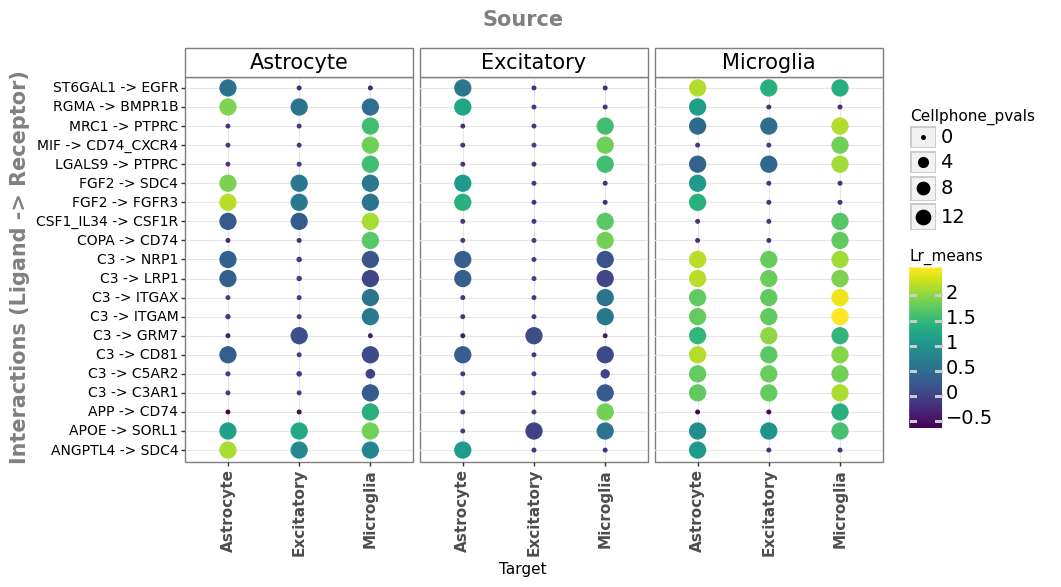

<ggplot: (719998886)>

In [10]:
print('=====================================')
print('visualization LR dotplots in AD group')
print('=====================================')

li.pl.dotplot(
    adata=adata_cond['stim'],
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=["Excitatory", "Microglia", "Astrocyte"],
    target_labels=["Excitatory", "Microglia", "Astrocyte"],
    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    filterby="cellphone_pvals",
    filter_lambda=lambda x: x <= 0.01,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="lr_means",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

visualization LR dotplots in WT group


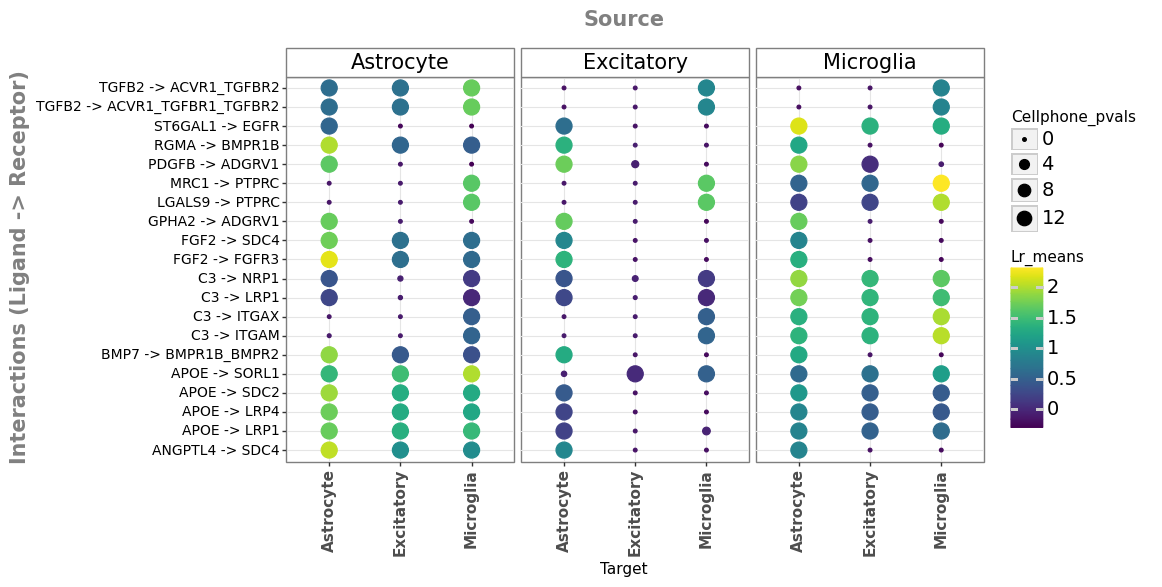

<ggplot: (707952304)>

In [11]:
print('=====================================')
print('visualization LR dotplots in WT group')
print('=====================================')


li.pl.dotplot(
    adata=adata_cond['ctrl'],
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=["Excitatory", "Microglia", "Astrocyte"],
    target_labels=["Excitatory", "Microglia", "Astrocyte"],
    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    filterby="cellphone_pvals",
    filter_lambda=lambda x: x <= 0.01,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="lr_means",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

In both cases, we get a number of interactions potentially linked to AD (`1596978330`) and normal (`1639097897`).

We can also see that both the magnitude (expression strength) and specificity of the interactions are cell-type dependent. For example, the potential binding of C3 binding to ITGAM logically occurs only when the receiver cells are Microglia.

### 2.4.2 **Generating a Ligand-Receptor consensus with `LIANA`**

As a way to further increase the confidence in a potential interaction of interest, one could check if this interaction is predicted as relevant by more than a single method. This is important given the reported limited agreement between the interactions inferred by different ligand-receptor methods.

In the same manner, we use multiple methods and focus on their consensus, or in other words focus on interactions consistently predicted as relevant. To this end, we will run the `rank_aggregate` method of `liana` [**Dimitrov et al., 2022**](https://www.nature.com/articles/s41467-022-30755-0), which generates a probability distribution of highly ranked interactions across the methods.

This will be done in a separate notebook due to memory constraints

In [12]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


### 2.4.3 **Heat Map**


In [23]:
def plot_interaction_scores(adata_cond: dict, 
                            top_n: int = 10, 
                            cell_types: list = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia'],): 

    def select_top(df, top_n):
        return df.nlargest(top_n, 'cellphone_pvals')

    for cell_type in cell_types:
        xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']

        # subset data from a specific source cell-type 
        scores_stim = adata_cond['stim'].uns['liana_res'][adata_cond['stim'].uns['liana_res'].source==cell_type]
        # sort by pvalues
        scores_stim.sort_values(by='cellphone_pvals', inplace=True)
        # select only significan pvalues 
        scores_stim = scores_stim[scores_stim.cellphone_pvals<0.01]
        # compute -log10(Score) for interpretability
        scores_stim['Interaction score'] = -np.log10(scores_stim['lr_means'])
        # create Ligand --> Receptor Pair Naming convention
        scores_stim['lr_pair'] = scores_stim['ligand_complex'] + ' --> ' + scores_stim['receptor_complex']
        # reset index
        scores_stim.set_index('lr_pair', inplace=True)

        # group dataframe by cell type and apply select top _n_ LR Pairs (ordered by P values) in each group
        scores_stim = scores_stim.groupby('target').apply(select_top, top_n)
        scores_stim = scores_stim.droplevel(0)

        scores_stim = pd.pivot_table(scores_stim, values='Interaction score', index='lr_pair', columns='target')
        scores_stim = scores_stim[xticks]


        # subset data from a specific source cell-type 
        scores_ctrl = adata_cond['ctrl'].uns['liana_res'][adata_cond['stim'].uns['liana_res'].source==cell_type]
        # sort by pvalues
        scores_ctrl.sort_values(by='cellphone_pvals', inplace=True)
        # select only significan pvalues 
        scores_ctrl = scores_ctrl[scores_ctrl.cellphone_pvals<0.01]
        # compute -log10(Score) for interpretability
        scores_ctrl['Interaction score'] = -np.log10(scores_ctrl['lr_means'])
        # create Ligand --> Receptor Pair Naming convention
        scores_ctrl['lr_pair'] = scores_ctrl['ligand_complex'] + ' --> ' + scores_ctrl['receptor_complex']
        # reset index
        scores_ctrl.set_index('lr_pair', inplace=True)

        # group dataframe by cell type and apply select top _n_ LR Pairs (ordered by P values) in each group
        scores_ctrl = scores_ctrl.groupby('target').apply(select_top, top_n)
        scores_ctrl = scores_ctrl.droplevel(0)
        scores_ctrl = pd.pivot_table(scores_ctrl, values='Interaction score', index='lr_pair', columns='target')
        scores_ctrl = scores_ctrl[xticks]



        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 6), gridspec_kw={'width_ratios':[0.85,1]}, sharex=False, layout='constrained')
        fig.tight_layout()


        yticks_stim = scores_stim.index
        yticks_ctrl = scores_ctrl.index
        g1 = sb.heatmap(scores_ctrl, cmap='bwr', center=0, vmin=-2.5, vmax=2.5, robust=False, annot=None, fmt='.1g', 
                        linewidths=0.10, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.2}, cbar=False,
                        cbar_ax=None, square=False, ax=ax1, xticklabels=xticks, yticklabels=yticks_ctrl, mask=None,) 

        g1.set_title('Control', fontsize=4)           
        g1.set_ylabel('')
        g1.set_xlabel('')


        g2 = sb.heatmap(scores_stim, cmap='bwr', center=0, vmin=0, vmax=3, robust=False, annot=None, fmt='.1g', 
                        linewidths=0.10, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.2},
                        cbar_ax=None, square=False,ax=ax2, xticklabels=xticks, yticklabels=yticks_stim, mask=None,) 


        cax = g2.figure.axes[-1]

        g2.set_title('AD', fontsize=4)           
        g2.set_ylabel('')
        g2.set_xlabel('')
        g2.yaxis.set_label_position('right')


        ax1.tick_params(axis='both', which='major', labelsize=2.5, length=1.5, width=0.5)
        ax2.tick_params(axis='both', which='major', labelsize=2.5, length=1.5, width=0.5)
        cax.tick_params(labelsize=4, length=1.5, width=0.5, which="major")
        plt.suptitle(cell_type, fontsize=6)


        plt.tight_layout()
        plt.savefig(f'../results/CellPhoneDB_top_{top_n}_LR_pairs_in_{cell_type}_source.pdf', bbox_inches='tight')
        plt.show(block=False)  
    return 



/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


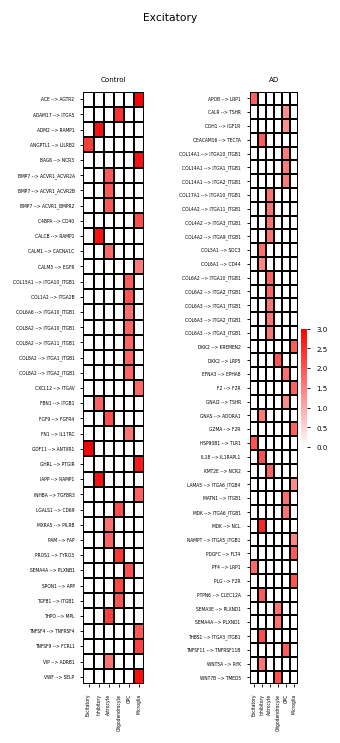

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


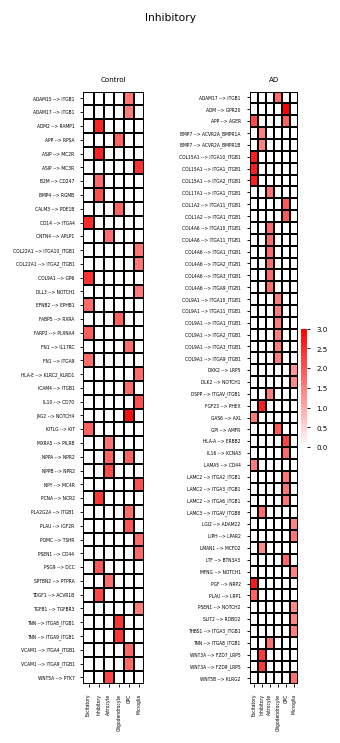

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


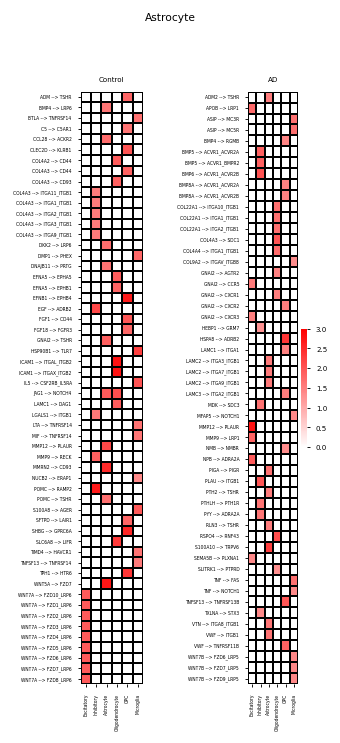

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


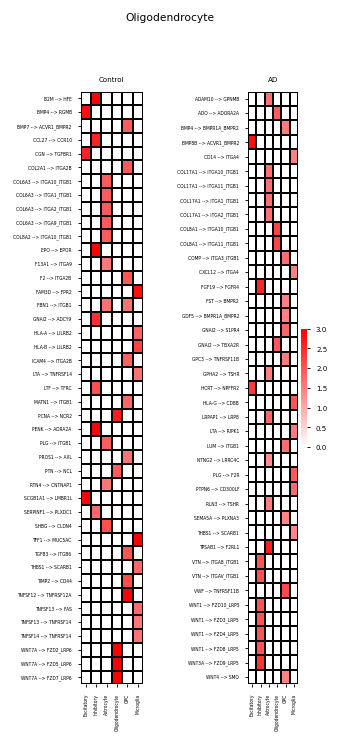

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


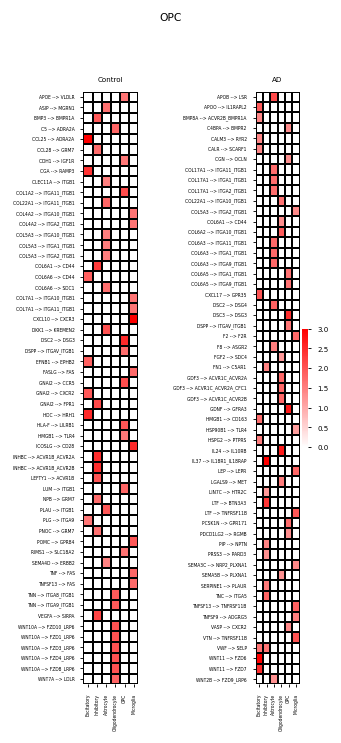

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_7490/3174569631.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


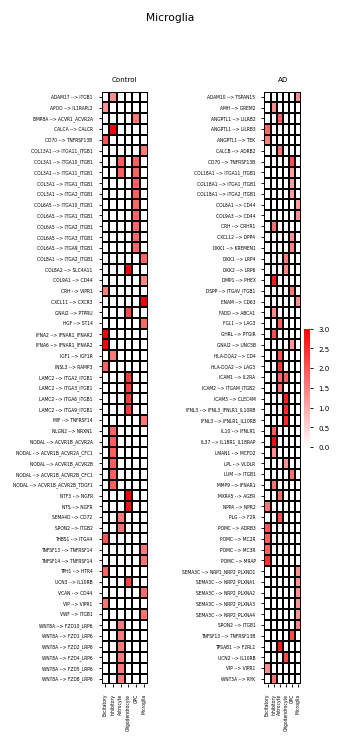

In [24]:
plot_interaction_scores(adata_cond, top_n=10, cell_types=['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']) 